# $MAPF_R$ environment

$MAPF_R$ environment: a graph $G=(V,E)$, each node is associated with a location in $\mathbb{R}^d$ space, $d\in\{1,2,3\}$. Moreover, each node has a self-loop edge, that is $(s,s)\in E$ for all $s\in V$.

# Definition of a motion plan in $MAPF_R$ environment:

A motion plan is a sequence of (node, time) pairs 
$$
    plan = \{(s_i,t_i): i = 0,1,\ldots, K\}
$$

where $s_i\in V, (s_i,s_{i+1})\in E$, and $t_{i+1}\geq t_i$. An agent following such a plan travels from $s_i$ to $s_{i+1}$ at constant velocity during the time interval $[t_i,t_{i+1}]$. If $s_i=s_{i+1}$, then the agent stays at the same node for the corresponding period.

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

import sys
sys.path.append('../')

sys.path.append('../../')

from panav.util import interpolate_positions, mergeIntervals

from matplotlib.animation import FuncAnimation

%load_ext autoreload
%autoreload 2

In [2]:
node_locs = np.array([[1,1],
                      [0,2],
                      [1,3],
                      [3,3],
                      [4,2],
                      [3,1]])
N = len(node_locs)

G = nx.DiGraph()
G.add_nodes_from(range(N))
edges = [(0,1),
          (1,2),
          (2,3),
          (3,4),
          (4,5),
          (5,0),
          (0,3)]

G.add_edges_from(edges)
G.add_edges_from(e[::-1] for e in edges)

# We manually add the bi-directional edges here, because
# using nx.to_directed(a undirected graph) causes issue when accessing edge values.

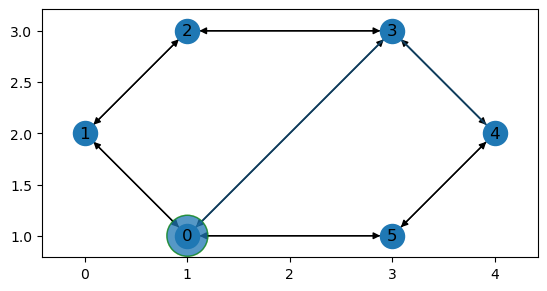

In [3]:
start_node = 0
goal_node = 4

agent_loc = node_locs[start_node]
bloating_r = 0.2

v_max = 1

tau1 = np.linalg.norm(node_locs[0]-node_locs[3])/v_max
tau2 = 1.5
tau3 = np.linalg.norm(node_locs[3]-node_locs[4])/v_max

G_plan = [(0,0),
        (3,tau1),
        (3,tau1+tau2),
        (4,tau1+tau2+tau3)]

x = np.vstack([node_locs[s] for s,t in G_plan]).T
t = np.array([t for s,t in G_plan])

dt = 0.1

t,x = interpolate_positions(t,x,dt)

from matplotlib.patches import Circle
from panav.viz import animation
from panav.env import NavigationEnv

fig = plt.figure()
ax = plt.gca()
nx.draw_networkx(G, {n:node_locs[n] for n in G},ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

disc = Circle(agent_loc,bloating_r,fill = 'green',ec = 'g',alpha=0.5)
ax.add_artist(disc)
ax.set_aspect('equal')

env = NavigationEnv()
anim  = animation(env,[x],bloating_r,dt,fig,ax,[disc])

In [4]:
from IPython.display import HTML, display

display(HTML(anim.to_jshtml()))
plt.close() 

# Compute Unsafe and Safe Intervals
Input: the trajectory of a dynamic obstacle, the velocity of the agent(constant, $v_{\max}$).

Assumption: the obstacle travels at constant speeds when traversing edges, the speeds on different edges can be different. The agent always travels at $v_{\max}$.


In [5]:

def unsafe_to_safe(unsafe_intervals,t0=0):
    t_prev = t0
    safe_intervals = []

    for i in range(len(unsafe_intervals)):
        if t_prev<unsafe_intervals[i][0]:
            safe_intervals.append((t_prev,unsafe_intervals[i][0]))

        t_prev = unsafe_intervals[i][1]

    safe_intervals.append((t_prev,np.inf))
    return safe_intervals

In [6]:
obs_traj = G_plan # obs_traj is also in {(s_i,t_i):i=0,1,...} form.

l = len(G_plan)
vmax = 1.0

In [16]:
nx.set_edge_attributes(G,{e:[] for e in G.edges},'unsafe_intervals')
nx.set_edge_attributes(G,{e:[] for e in G.edges},'safe_intervals')
nx.set_edge_attributes(G,
                       {e:np.linalg.norm(node_locs[e[0]]-node_locs[e[1]])/vmax\
                          for e in G.edges},
                       'weight')

nx.set_node_attributes(G,{s:[] for s in G},'unsafe_intervals')
nx.set_node_attributes(G,{s:[] for s in G},'safe_intervals')


for i in range(l-1):
    (u,t1),(v,t2) = G_plan[i],G_plan[i+1]
    if u!=v:
        G.edges[v,u]['unsafe_intervals'].append([t1,t2])
        # print(G.edges[v,u]['unsafe_intervals'],G.edges[u,v]['unsafe_intervals'])
        
        
        vel = np.linalg.norm(node_locs[u]-node_locs[v])/(t2-t1)
        self_traverse_t = 2*bloating_r/vel
        
        if vmax>=vel: # The agent chases the obstacle
            gap_t = ((vmax-vel)*(t2-t1) + 2* bloating_r)/vmax
            G.edges[u,v]['unsafe_intervals'].append([t1,np.min([t2,t1+gap_t])])
        else: # The obstacle chases the agent
            gap_t = ((vel-vmax)*(t2-t1) + 2* bloating_r)/vmax
            G.edges[u,v]['unsafe_intervals'].append([np.max([0,t1-gap_t]),t1])
            
        # The following are caused by agent touching the start and nodes when traversing the edge.
        G.nodes[u]['unsafe_intervals'].append([t1,t1+self_traverse_t])
        G.nodes[v]['unsafe_intervals'].append([t2-self_traverse_t,t2])
    else: # u==v
        G.nodes[u]['unsafe_intervals'].append([t1,t2])

for i in G:
    G.nodes[i]['unsafe_intervals'] = mergeIntervals(G.nodes[i]['unsafe_intervals'])
    G.nodes[i]['safe_intervals'] = unsafe_to_safe( G.nodes[i]['unsafe_intervals'])

for e in G.edges:
    G.edges[e]['unsafe_intervals']=mergeIntervals(G.edges[e]['unsafe_intervals'])
    G.edges[e]['safe_intervals']=unsafe_to_safe(G.edges[e]['unsafe_intervals'])
 
    
unsafe_intervals = G.nodes[0]['unsafe_intervals']

t0 = 0



# $A^*$ algorithm

In [86]:
from queue import PriorityQueue

In [91]:
def safe_interval_index(G,t,s):
    '''
        Given the graph G, determine which safe interval of node s does time t fall into.
        
        If t is not in any safe intervals, return None.
    '''
    intervals = G.nodes[s]['safe_intervals']
    
    for i in range(len(intervals)):
        if intervals[i][0]<=t<=intervals[i][1]:
            return i
    
    return None

def recover_path(final_state,start,cameFrom,transition_duration):
    path = []
    curr = final_state
    while curr != (start,0,0):
        path.append((curr[0],transition_duration[curr]))
        curr = cameFrom[curr]
    
    path.reverse()
    
    
    transitions = [(start,0)]
    prev_node = start
    t_prev = 0
    for i in range(len(path)):
        dest_node,duration = path[i]
        
        if t_prev<duration[0]:# The agent waited at prev node
            transitions.append((prev_node,duration[0]))
        
        transitions.append((dest_node,duration[1]))
        t_prev = duration[1]
        prev_node = dest_node
        
    return transitions

def intersection(interval1,interval2):
    lb,ub = max([interval1[0],interval2[0]]),min([interval1[1],interval2[1]])
    if lb>=ub:
        return None
    else:
        return (lb,ub)
                                        

In [92]:

start = 3
goal = 0

hScore = dict(nx.shortest_path_length(G,weight = 'weight'))

In [93]:
OPEN = PriorityQueue()
t0 = 0

safe_idx = safe_interval_index(G,t0,start)

if safe_idx is None:
    print('The starting time {} is unsafe at node {}'.format(t0,start))

gScore = {(start,safe_idx,0):0}
# gScore[s,idx,k] keeps track of the travel time from the start node to 
# node s, arriving at the idx'th safe interval of s, at at k'th hop.

OPEN.put((0,(start,safe_idx,0))) 

# Items in the priority queue are in the form (gScore, item), sorted by value. 
# The item with the smallest value is placed on top.

cameFrom = {}
transition_duration = {}

path = []

while not OPEN.empty():
    curr_fscore,(s,i,k) = OPEN.get() # Remove the (s, i, k) with the smallest gScore.
    if s == goal:
        # return recover_path((s,i,k),start,cameFrom)
        path = recover_path((s,i,k),start,cameFrom,transition_duration)
        break
    
    t = gScore[(s,i,k)]
    LB,UB = G.nodes[s]['safe_intervals'][safe_interval_index(G,t,s)]
    
    for u in G[s]:
        l = G.edges[s,u]['weight']
        start_t = t + l
        end_t = UB + l
        for lb,ub in G.nodes[u]['safe_intervals']:
            int1 = intersection((lb,ub),(start_t,end_t))
            if int1:
                for m,(lbp,ubp) in enumerate(G.edges[s,u]['safe_intervals']):
                    int2 = intersection((lbp,ubp),np.array(int1)-l)
                    if int2:
                        a,b = int2
                        if (u,m,k+1) not in gScore.keys():
                            gScore[(u,m,k+1)] = np.inf
                            
                        if a+l<gScore[(u,m,k+1)]:
                            cameFrom[(u,m,k+1)] = (s,i,k)
                            gScore[(u,m,k+1)] = a+l
                            transition_duration[(u,m,k+1)] = (a,a+l)
                            fScore = a+l+hScore[u][goal]
                            OPEN.put((fScore,(u,m,k+1)))
                        
                        
                    

In [94]:
path

[(3, 0), (2, 2.0), (1, 3.414213562373095), (0, 4.82842712474619)]

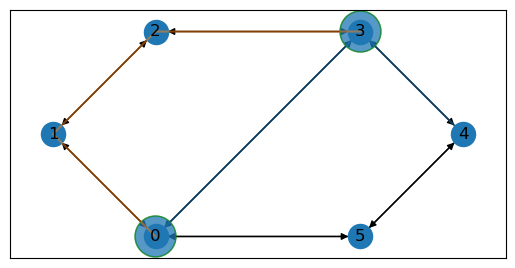

In [98]:
xs = []
ts = []

dt = 0.1

for p in [G_plan,path]:
    x = np.vstack([node_locs[s] for s,t in p]).T
    t = np.array([t for s,t in p])
    t,x = interpolate_positions(t,x,dt)
    
    xs.append(x)
    ts.append(t)

from matplotlib.patches import Circle
from panav.viz import animation
from panav.env import NavigationEnv

fig = plt.figure()
ax = plt.gca()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
nx.draw_networkx(G, {n:node_locs[n] for n in G},ax)


discs = []
for loc in [node_locs[0],node_locs[3]]:
    disc = Circle(loc,bloating_r,fill = 'green',ec = 'g',alpha=0.5)
    ax.add_artist(disc)
    discs.append(disc)

ax.set_aspect('equal')

env = NavigationEnv()
anim  = animation(env,xs,bloating_r,dt,fig,ax,discs)

In [99]:
from IPython.display import HTML, display

display(HTML(anim.to_jshtml()))
plt.close() 